In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('tedx_dataset.csv')
print(df.head())

                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

In [4]:
df.shape

(4467, 7)

In [5]:
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [6]:
splitted = df['posted'].str.split(' ', expand=True)
# Creating columns for month and year of the talk
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

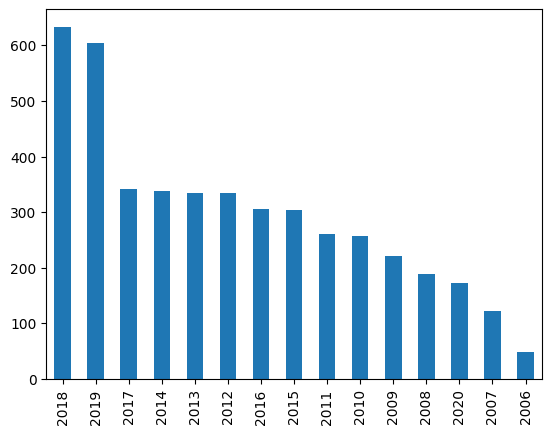

In [7]:
df['year'].value_counts().plot.bar()
plt.show()

In [8]:
# Let's combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['details']
# Removing the unnecessary information
df = df[['main_speaker', 'details']]
df.dropna(inplace = True)
df.head()

,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


In [9]:
# We would like to have a copy of our data for future use.
data = df.copy()

In [10]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')
  imp_words = []
  # Storing the important words
  for word in str(text).split():
    word = word.lower()
    if word not in stop_words:
      imp_words.append(word)
  output = " ".join(imp_words)
  return output

In [11]:
df['details'] = df['details'].apply(lambda text: remove_stopwords(text))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


In [12]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)
df['details'] = df['details'].apply(lambda x: cleaning_punctuations(x))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


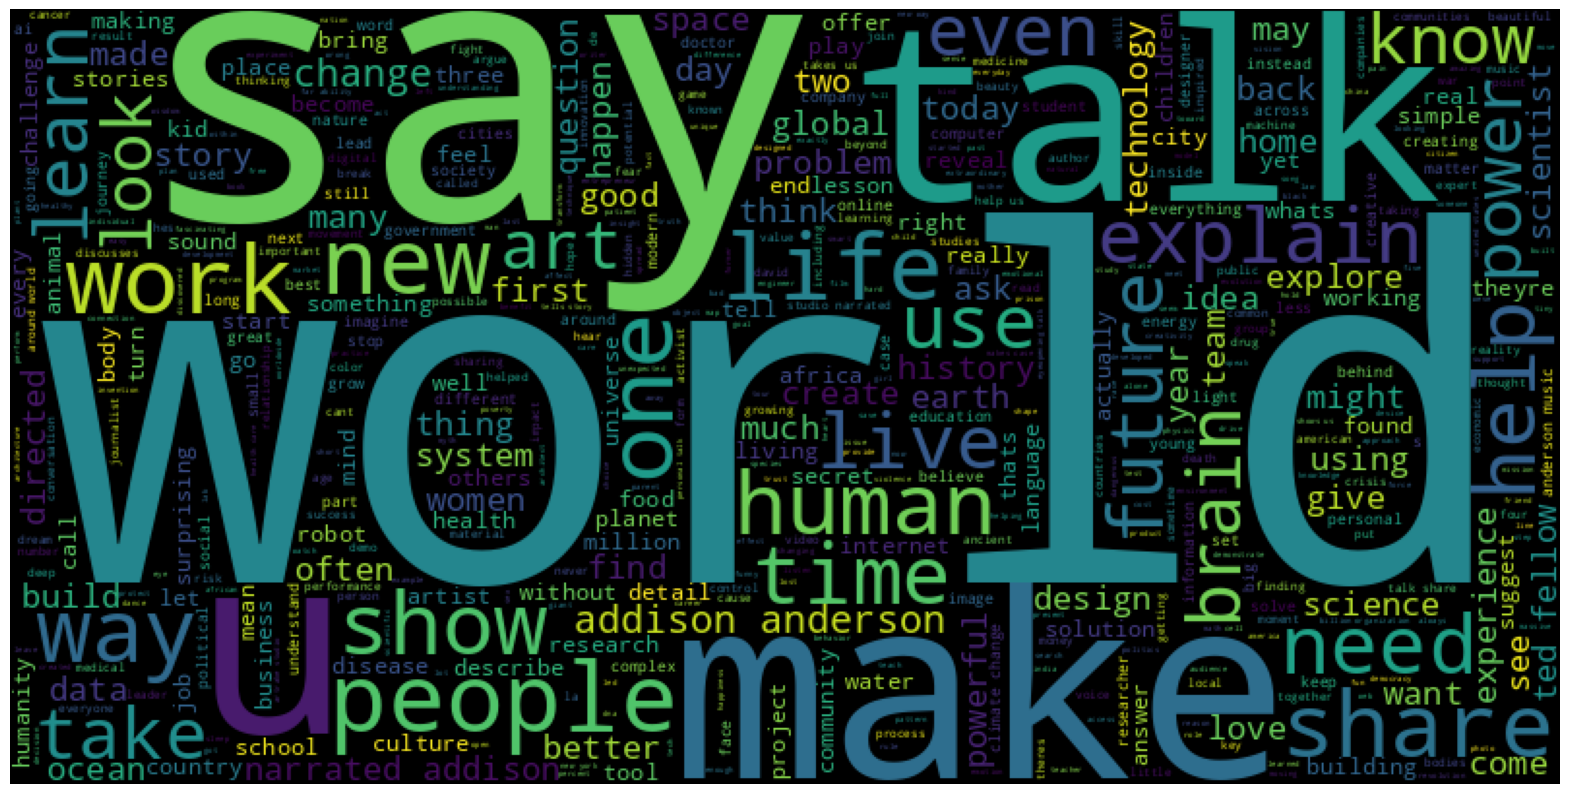

In [13]:
details_corpus = " ".join(df['details'])
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=1000,
               width=800,
               height=400).generate(details_corpus)
plt.axis('off')
plt.imshow(wc)
plt.show()

In [14]:
%%capture
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

In [15]:
def get_similarities(talk_content, data=df):
    # Getting vector for the input talk_content.
    talk_array1 = vectorizer.transform(talk_content).toarray()
    # We will store similarity for each row of the dataset.
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']
        # Getting vector for current talk.
        talk_array2 = vectorizer.transform(
            data[data['details'] == details]['details']).toarray()
        # Calculating cosine similarities
        cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]
        # Calculating pearson correlation
        pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]
        sim.append(cos_sim)
        pea.append(pea_sim)
    return sim, pea

In [16]:
def recommend_talks(talk_content, data=data):
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
                     False, False], inplace=True)
    display(data[['main_speaker', 'details']].head())

In [17]:
talk_content = ['Time Management and working\nhard to become successful in life']
recommend_talks(talk_content)

,main_speaker,details
1758,Laura Vanderkam,How to gain control of your free time There ar...
2173,Philip Krinks,Finding your personal mission in life Philip K...
66,Fang Ruan,Management lessons from Chinese business and p...
2075,Jessica Shortall,The US needs paid family leave — for the sake ...
2446,Susan Etlinger,What do we do with all this big data? Does a s...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [18]:
talk_content = ['Climate change and impact on the health\
. How can we change this world by reducing carbon footprints?']
recommend_talks(talk_content)

,main_speaker,details
798,J. Marshall Shepherd,3 kinds of bias that shape your worldview What...
560,Guy Harvey,Painting sharks ... for science Artist and mar...
3264,Melinda Gates,Let's put birth control back on the agenda Con...
1935,Lidia Yuknavitch,The beauty of being a misfit To those who feel...
322,Mitchell Katz,What the US health care system assumes about y...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('main_speaker').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('details').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['details'].value_counts()
    for x_label, grp in _df_2.groupby('main_speaker')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('main_speaker')
_ = plt.ylabel('details')

In [19]:
import pickle

In [22]:
filename = 'tedtalks_recommendation.sav'
pickle.dump(recommend_talks, open(filename, 'wb'))

In [23]:
# loading the saved model
loaded_model = pickle.load(open('tedtalks_recommendation.sav', 'rb'))

In [25]:
for column in df.columns:
  print(column)

main_speaker
details
